In [1]:
!pip install torch transformers datasets nltk seaborn matplotlib rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using ca

In [4]:
# Import libraries
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
import torch.optim as optim
from datasets import load_dataset
from rouge_score import rouge_scorer

# Download NLTK tokenizer data
nltk.download('punkt')

# Load and Preprocess the Dataset
# Load only a very small subset of the CNN/Daily Mail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')  # Load the full dataset first
small_train_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.001))) # Select 0.1% after shuffling

# Convert to DataFrame and save to CSV
df = pd.DataFrame({
    'text': small_train_dataset['article'],
    'summary': small_train_dataset['highlights']
})

df.to_csv('cnn_dailymail_very_small_data.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


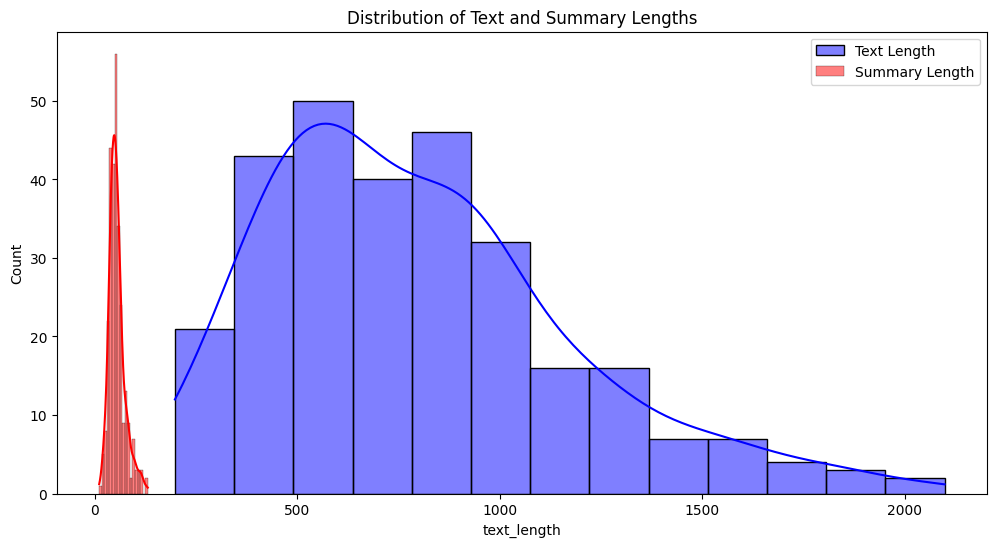

In [5]:
# Data insights
df['text_length'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['summary_length'] = df['summary'].apply(lambda x: len(nltk.word_tokenize(x)))

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, color='blue', label='Text Length')
sns.histplot(df['summary_length'], kde=True, color='red', label='Summary Length')
plt.legend()
plt.title('Distribution of Text and Summary Lengths')
plt.show()

In [6]:

# Define the Dataset Class
class CustomTextDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')  # Use a smaller model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, 0]
        summary = self.data.iloc[idx, 1]
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        targets = self.tokenizer(summary, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
        return inputs.input_ids.squeeze(), targets.input_ids.squeeze()

In [7]:
# Load dataset
data = pd.read_csv('cnn_dailymail_very_small_data.csv')
train_dataset = CustomTextDataset(data)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Reduce batch size


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [9]:
# Model Definition and Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device)  # Use a smaller model
optimizer = optim.AdamW(model.parameters(), lr=3e-5)


In [10]:
num_epochs = 1  # Reduce the number of epochs
training_loss = []

In [11]:
# Train the model minimally
model.train()
total_loss = 0
for batch in train_dataloader:
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(input_ids=inputs, labels=targets)
    loss = outputs.loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    break  # Train on just one batch for demonstration purposes


In [12]:
avg_loss = total_loss / 1
training_loss.append(avg_loss)
print(f'Training Loss: {avg_loss}')

Training Loss: 9.115382194519043


In [13]:
# Save the model
model.save_pretrained('summarization_model_demo')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


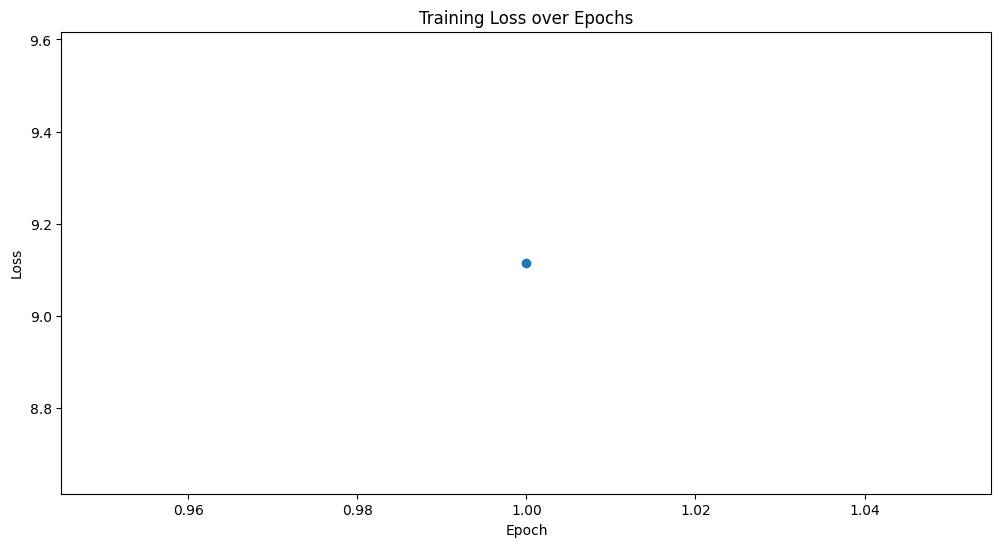

In [14]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [24]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')


In [28]:
# Define the Evaluation Function
def evaluate_model(model, dataloader, tokenizer, num_samples=5):
    model.eval()
    summaries = []
    references = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:  # Limit the number of samples for evaluation
                break
            inputs, targets = batch
            inputs = inputs.to(device)
            outputs = model.generate(inputs)
            decoded_summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in outputs]
            decoded_references = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=False) for t in targets]
            summaries.extend(decoded_summaries)
            references.extend(decoded_references)
    return summaries, references

In [29]:
val_summaries, val_references = evaluate_model(model, train_dataloader, tokenizer)


In [30]:
# Calculate ROUGE scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = { 'rouge1': [], 'rouge2': [], 'rougeL': [] }

for summary, reference in zip(val_summaries, val_references):
    scores = scorer.score(reference, summary)
    rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
    rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
    rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

In [31]:
# Average ROUGE scores
avg_rouge_scores = {k: sum(v) / len(v) for k, v in rouge_scores.items()}

In [32]:
# Print ROUGE scores
print("ROUGE-1: ", avg_rouge_scores['rouge1'])
print("ROUGE-2: ", avg_rouge_scores['rouge2'])
print("ROUGE-L: ", avg_rouge_scores['rougeL'])

ROUGE-1:  0.10396894285080069
ROUGE-2:  0.013119958365860005
ROUGE-L:  0.0879593331004198


In [33]:

# Visualize ROUGE scores
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores = [avg_rouge_scores['rouge1'], avg_rouge_scores['rouge2'], avg_rouge_scores['rougeL']]


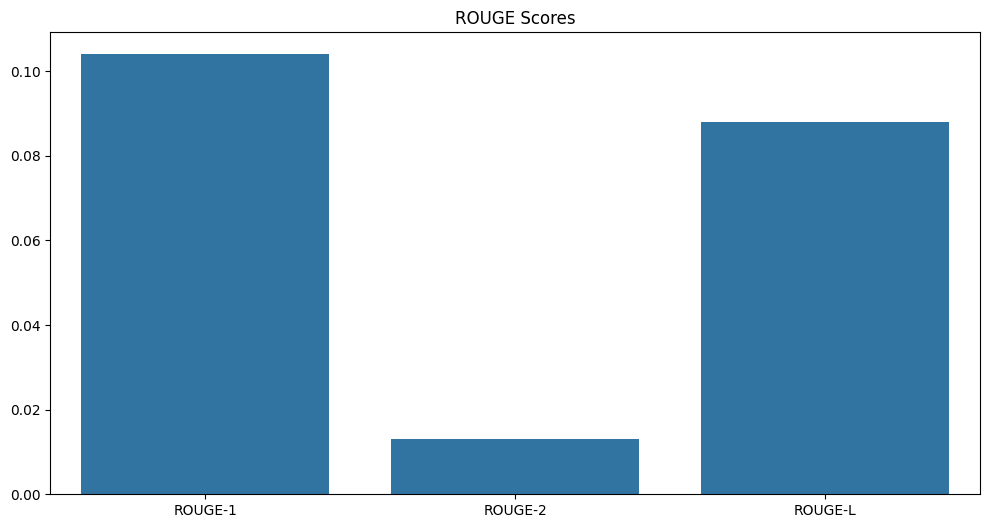

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=scores)
plt.title('ROUGE Scores')
plt.show()